# Trennung Signal-Background - Trainingsmengen erstellen

Die bereinigten Rohdaten stehen als CSV-Datei zur Verfügung.
Jede Instanz (Welle) besteht aus 100 diskreten Messwerten und dem Label, 
ob es sich um ein Signal oder ein Hintergrundrauschen handelt.

Es werden zwei verschiedene Trainingsmengen erstellt.
- Zum einen werden aus den Daten wichtige Kennzahlen (*features*) herangezogen.
Mit diesen Kenndaten werden dann klassische ML-Algorithmen zur binären Klassifizierung angewendet.
- Zum anderen wird ein Bereich der Messdaten, um den maximalen (negativen) Peak herum ausgewählt
und als Trainingsdaten für ein Neuronalen Netz zur aufbereitet.

Diese beiden Trainingsdaten werden erstellt und als CSV-Datei ausgegeben.
Eine dritte CSV-Datei enthält Informationen, die zur Darstellung von Daten benötigt werden.

Wird später verwendet
- features (Höhe Impuls, Breite Impuls, Höhe "Nachfolgeimpuls", Breite "NAchfolgeimpuls", Abstand zwichen Impuls und "Nachfolgeimpuls")


### Konstanten

In [1]:
# --- constants
LABEL_SIGNAL = 1
LABEL_BACKGROUND = -1

### Ein- und Ausgabedateien

In [2]:
# --- filenames for input- and putput-files
filename_inp = "data\sbDataComplete.csv"
filename_out = "data\sbData.csv"

### Parameter für die Steuerung

Die nachfolgenden Parameter steuern den Bereich der Daten, die um den maximalen (negativen) Impuls herausgelöst werden.
- `offset_left`: Beginn des Bereiches, links vom maximalen (negativen) Impuls
- `len_range`: Anzahl der Messpunkte des Datenbereiches

In [3]:
# --- Bereich für den Auszug aus der Welle
offset_left = 5
len_range = 25

### Import wichtiger Module

In [4]:
# --- imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

## Methoden zur Aufbereitung der einzelnen Instanzen

Aus den Rohdaten werden Daten für die Trainingsmengen extrahiert.

Für die klassichen ML-Algorithmen wird der maximale (negative) Impuls (im Folgenden *MaxPuls* genannt)
und der nachfolgende nächste maximale (positive) Impuls (im Folgenden *NextPuls* genannt) untersucht.
Es werden die nachfolgenden Daten bestimmt:
- `P2P_DIFF`: die vertikale Differenz zwischen MaxPuls und NextPuls
- `P2P_RATIO`: das Verhältnis zwischen den Höhen zwischen MaxPuls und NextPuls
- `P2P_DIST`: die horizontale Distanz zwischen MaxPuls und NextPuls
- `WIDTH1`: die Breite des Impulses auf halben Impulshöhe, beim MaxPuls
- `WIDTH2`: die Breite des Impulses auf halben Impulshöhe, beim NextPuls

Da Pulshöhe des maximalen (negativen) Impulses ist bei diesen Daten nur indirekt enthalten.
Diese maximale Pulshöhe wurde jedoch bereits bei der Aufbereitung der Daten verwendet, 
als Hintergrundsignale eliminiert wurden, deren maximale Pulshöhe eine Schwelle überschritten hat.

Für die Trainingsdaten des Neuronalen Netzes wird ein Bereich der 100-Pixel-Welle um den maximalen (negativen) Impuls herausgeholt
- Der Parameter `offset_left` bestimmt die Anzahl der Pixel die links vom maximalen (negativen) Impuls sind, die zum ausgewählten Bereich gehören.
- Der Parameter `len_range`bestimmt die Anzahl der Messdaten, die zum ausgewählten Bereich gehören
Die beiden Parameter werden in `range_data`zusammengefasst.

Im Nachfolgenden sind einige Hilfsroutinen aufgeführt.

In [5]:
# --- find start position of the data range
def find_max_impulse_range (wave, offset_left, len_range):
    pos_max_impuls = wave.argmin ()
    pos_from = max (0, pos_max_impuls - offset_left)
    pos_from = min (pos_from, len (wave) - len_range)
    return pos_from

In [6]:
# --- get the width of the pulse
def get_width (wave, pos):
    peaks = find_peaks (wave) [0]
    widths, _, _, _ = peak_widths (wave, peaks, rel_height=0.5)
    find_pos = np.where (peaks == pos)
    # - - for some peaks, more as 1 position has the max value,
    #     than the seconsd position of the peak is used
    if (len (find_pos [0]) == 0): # position of peak not found!
        find_pos = np.where (peaks == (pos + 1))
    width = (widths [find_pos]) [0]
    return width 

In [7]:
# --- find the max (negative) peak and the next (positive) peak 
def find_signal_peaks (wave):
    # --- height and width of the max (negative) pulse
    position_neg_peak = wave.argmin ()
    if (position_neg_peak == 0) or (position_neg_peak == (len (wave) - 1)):
        position_neg_peak = wave [5:-5].argmin () + 5      
    # - - if the peak is at the beginning o at the end (can happen for background, 
    #     for signal it should be eliminated by the preparation of the raw data)
    height1 = -wave [position_neg_peak]
    width1 = get_width (-wave, position_neg_peak)

     # ---  height and width of the pulse after the max pulse
    position_pos_peak = wave [position_neg_peak:].argmax () + position_neg_peak
    height2 = wave [position_pos_peak]

    if (position_pos_peak > 95):
        #print ("Aufruf get_width / pos = ", position_pos_peak, position_neg_peak)
        width2 = 2 * (100 - position_pos_peak)
    else:
        width2 = get_width (wave, position_pos_peak)
    # --- difference and ratio between the two pulse
    p2p_diff = height1 + height2
    p2p_ratio = height1 / height2
    # --- distance between the two pulses
    p2p_dist = position_pos_peak - position_neg_peak

    return [height1, height2, p2p_diff, p2p_ratio, p2p_dist, width1, width2]

In [8]:
def create_line (data_org, index, pos_from, pos_till, pos_peak, features, label, \
                 normalization=False, with_origin=True):
    new_line = np.array([])
    if with_origin:
        new_line = np.concatenate ((new_line, data_org))
    new_line = np.concatenate ((new_line, [index, pos_from, pos_till, pos_peak]))
    
    wave = data_org [pos_from:pos_till]
    impulse = features [0]
    if normalization:
        factor = 32000 / impulse
        wave = wave * factor
    new_line = np.concatenate ((new_line, wave))

    new_line = np.concatenate ((new_line, features))
    new_line = np.concatenate ((new_line, [label]))
    return new_line

In [9]:
def prepare (data, offset_left=4, len_range=25, normalization=False, with_origin=True):
    """ 
    out1: Daten für Neuronale Netz
    out2: Daten für klassische ML-Algorithmen
    info: Informationen
    Ausgabeformat für eine Welle in data_out:
        len_range Punkte für das Signal, von Position (position des maximalen Impulses
            - offset_left)
        Index der Originaldaten
        Label

    Ausgabeforma für info_out: (Könnte dies in die data_out integriert werden? 
        Diese Daten sollen aber nicht für den Lernprozess genutzt werden!)
        Index der Originaldaten
        Absolutbetrag des maximalen Impulses
        Erste Position des Auschnitts aus der Welle
        Letzte Position des Ausschnitts aus der Welle
    """

    # --- adjust wave data: median (for each instance) = 0.0
    wave_data = data [:,:-1]
    wave_0 = np.median (wave_data, axis = 1)
    wave_data = wave_data - wave_0.reshape (wave_0.shape [0], 1)

    # --- find value and position of max impulse of each instance
    impulse = - wave_data.min (axis = 1)
    pos_max_impulse = wave_data.argmin (axis = 1)

    # --- fetch region of max impulse
    wave_length = wave_data.shape [1]
    range_right = wave_length - 1 + offset_left - len_range
    #     --- adjust region, completly in wave
    pos_max_impulse [pos_max_impulse < offset_left] = offset_left
    pos_max_impulse [pos_max_impulse > range_right] = range_right
    pos_from = pos_max_impulse - offset_left
    pos_till = pos_from + len_range

    #     --- fetch line for line
    data_out = np.empty ((0,137))
    for ind in range (wave_data.shape [0]):
        features = find_signal_peaks (wave_data [ind])
        new_line = create_line (wave_data [ind], ind, pos_from [ind], pos_till [ind], pos_max_impulse [ind], features, data [ind,-1], \
                                normalization=normalization, with_origin=with_origin)
        data_out = np.vstack ( (data_out, new_line) )

    #n1 = len (data_out)
    #n2 = data.shape [0]
    #print (n1, n2)
    #data_out = data_out.reshape (n2, n1 // n2) 
    return data_out 


### Rohdaten einlesen

In [10]:
# --- load data from CSV-file
print (f"  load data from : ", filename_inp)
data_org = np.loadtxt (filename_inp, delimiter=";", skiprows=1)
n_instances = len (data_org)
print (f"  number of loaded instances: {n_instances:d}")

  load data from :  data\sbDataComplete.csv
  number of loaded instances: 23754


## Plotten einiger Beispielwellen
Es werden einige Beispiele von Wellen geplottet. Dabei werden die Messpunkte, die 0_linie (grün) und die Welle dargestellt.
Die Messdaten der Welle sind 100 diskrete Messwerte.

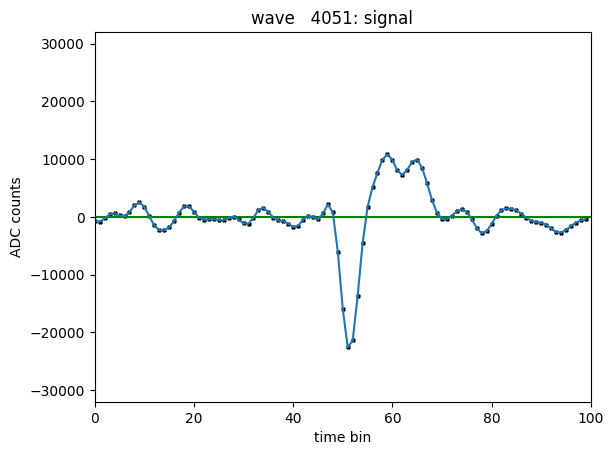

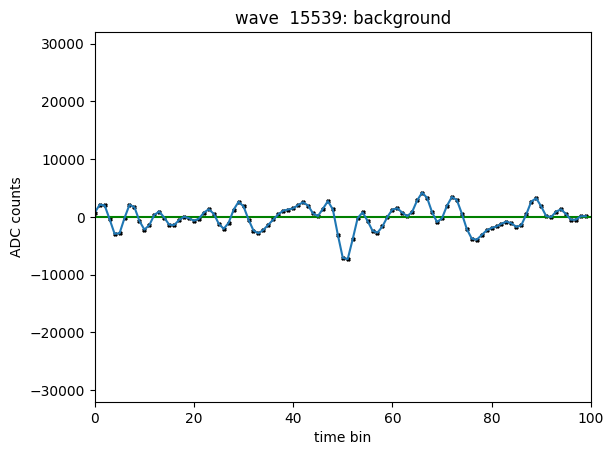

In [11]:
# --- plot same examples
n_examples = 4

def get_label (label):
    if (label == LABEL_SIGNAL):
        return "signal    "
    else:
        return "background"

def show_SignalWaveForm (wave, title, withPlot=True):
    plt.ylabel ("ADC counts")
    plt.xlabel ("time bin")
    plt.title (title)
    plt.xlim (0, 100)
    plt.ylim (-32000, 32000)
    x_plt = np.linspace (0, len (wave), len (wave), endpoint=False)
    plt.hlines ([0],[0],[100], colors='green')
    plt.scatter (x_plt, wave, s=5.0, c='black', marker='X')
    if withPlot:
        plt.plot (x_plt, wave)
    #plt.show ()
    
# 03825s, 04051s, 15539b, 07650s
#examples = [3825, 4051, 15539, 7650, 32, 14616]
examples = [4051, 15539]
for ind in examples: #range (n_examples):
#    ind = np.random.randint (0, n_instances - 1)
    data_wave = data_org [ind,:-1]
    data_label = data_org [ind,-1]
    title = f"wave {ind:6d}: {get_label (data_label)}"
    show_SignalWaveForm (data_wave, title, withPlot=True)
    filename = f"RawWave{ind}plot.png"
    #plt.savefig (filename)
    plt.show ()


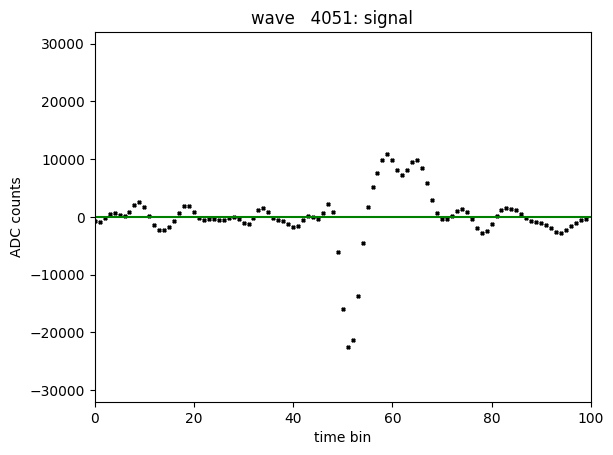

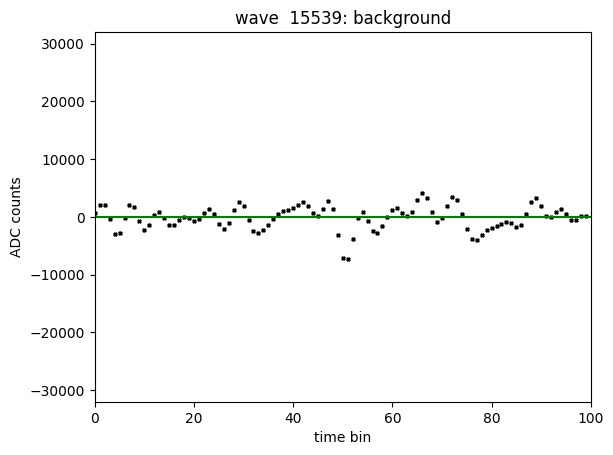

In [12]:
examples = [4051, 15539]
for ind in examples: #range (n_examples):
#    ind = np.random.randint (0, n_instances - 1)
    data_wave = data_org [ind,:-1]
    data_label = data_org [ind,-1]
    title = f"wave {ind:6d}: {get_label (data_label)}"
    show_SignalWaveForm (data_wave, title, withPlot=False)
    filename = f"RawWave{ind}scat.png"
    #plt.savefig (filename)
    plt.show ()

### Trainingsmengen erstellen

In [13]:
# --- prepare the learning set plus additional information
#     --- parameter setting

data_out \
    = prepare (data_org, \
               offset_left=offset_left, len_range=len_range, \
               normalization=True, with_origin=True)
print (len (data_out))


23754


In [14]:
def get_CSVheader (char, n):
    header = ""
    for ind in range (n):
        new_text = char + str(ind) + ";"
        header = header + new_text
    return header
# --- prepare the learning set plus additional information
#     --- parameter setting

# --- save data as csv
header = get_CSVheader ("P", 100) 
header = header + "INDEX;POS_FROM;POS_TILL;POS_PEAK;" 
header = header + get_CSVheader ("C", len_range)
header = header + "PEAK1;PEAK2;P2P_DIFF;P2P_RATIO;P2P_DIST;WIDTH1;WIDTH2;LABEL"
np.savetxt (filename_out, data_out, fmt="%12.5e", delimiter=";", header=header, comments="")

print ("data out   : ", data_out.shape)
print ("number of instances : ", len (data_out))

data out   :  (23754, 137)
number of instances :  23754
